# 네이버 영화리뷰 감정 분석에 SentencePiece 적용하기

## 목표
1. 네이버 영화리뷰 감정 분석 코퍼스에 SentencePiece를 적용시킨 모델 학습하기
2. 학습된 모델로 `sp_tokenize()` 메소드 구현하기
3. 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습하기
4. KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기
5. SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기

## 루브릭
|학습목표|평가기준|
|---|---|
|SentencePiece를 이용하여 모델을 만들기까지의 과정이 정상적으로 진행되었는가?|코퍼스 분석, 전처리, SentencePiece 적용, 토크나이저 구현 및 동작이 빠짐없이 진행되었는가?|
|SentencePiece를 통해 만든 Tokenizer가 자연어처리 모델과 결합하여 동작하는가?|SentencePiece 토크나이저가 적용된 Text Classifier 모델이 정상적으로 수렴하여 80% 이상의 test accuracy가 확인되었다.|
|SentencePiece의 성능을 다각도로 비교분석하였는가?|SentencePiece 토크나이저를 활용했을 때의 성능을 다른 토크나이저 혹은 SentencePiece의 다른 옵션의 경우와 비교하여 분석을 체계적으로 진행하였다.|

## 1. 네이버 영화리뷰 코퍼스에 SentencePiece 적용시키기

In [1]:
# !wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
# !wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt

In [2]:
import pandas as pd

train_df = pd.read_table('ratings_train.txt')
test_df = pd.read_table('ratings_test.txt')

train_df.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


초기 훈련 데이터 개수: 150000
초기 테스트 데이터 개수: 50000
결측치 제거 후: 149995개
중복 제거 후: 146182개
반복 문자 정규화를 적용했습니다.
자음/모음만 있는 리뷰 제거 후: 146059개
문자 길이 3 미만 리뷰 제거 후: 145594개

--- 문자 길이 분포 (전처리 후) ---
count    145594.000000
mean         35.959435
std          29.445082
min           3.000000
25%          16.000000
50%          27.000000
75%          43.000000
max         146.000000
Name: document, dtype: float64


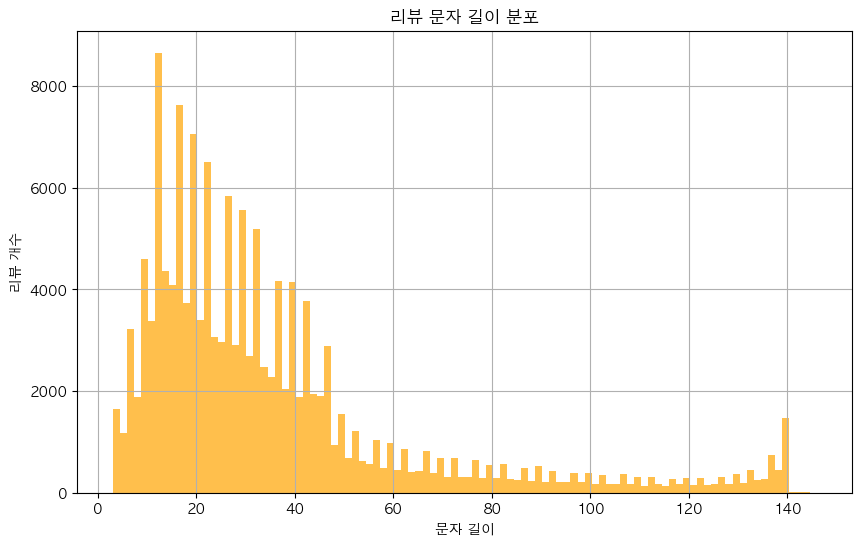


최대 문자 길이를 140으로 제한하여 문장을 잘랐습니다.

최종 정제된 훈련 데이터 개수: 145594


In [3]:

import numpy as np
import matplotlib.pyplot as plt
from soynlp.normalizer import emoticon_normalize

# --- 1. 초기 데이터 로드 및 기본 전처리 ---

print(f'초기 훈련 데이터 개수: {len(train_df)}')
print(f'초기 테스트 데이터 개수: {len(test_df)}')

# 결측치 제거
train_df.dropna(inplace=True)
print(f'결측치 제거 후: {len(train_df)}개')

# 중복 데이터 제거
train_df.drop_duplicates(subset=['document'], inplace=True)
print(f'중복 제거 후: {len(train_df)}개')


# --- 2. 내용 기반 전처리 ---

# 'document' 열의 모든 텍스트에 emoticon_normalize 적용
train_df['document'] = train_df['document'].apply(lambda x: emoticon_normalize(x, num_repeats=2))
print('반복 문자 정규화를 적용했습니다.')

# 한글 자음/모음만 있는 리뷰 제거
train_df = train_df[~train_df['document'].str.match('^[ㄱ-ㅎㅏ-ㅣ]+$', na=False)]
print(f"자음/모음만 있는 리뷰 제거 후: {len(train_df)}개")


# --- 3. 길이 기반 전처리 ---

# 최소 길이 미만 리뷰 제거
min_char_len = 3
train_df = train_df[train_df['document'].str.len() >= min_char_len]
print(f"문자 길이 {min_char_len} 미만 리뷰 제거 후: {len(train_df)}개")

# 리뷰 문자 길이 분포 확인
char_lengths = train_df['document'].str.len()
print('\n--- 문자 길이 분포 (전처리 후) ---')
print(char_lengths.describe())

# 분포 시각화
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(10, 6))
plt.hist(char_lengths, bins=100, alpha=0.7, color='orange')
plt.title('리뷰 문자 길이 분포')
plt.xlabel('문자 길이')
plt.ylabel('리뷰 개수')
plt.grid(True)
plt.show()

# 최대 길이를 기준으로 자르기
max_char_len = 140
train_df['document'] = train_df['document'].str.slice(0, max_char_len)
print(f'\n최대 문자 길이를 {max_char_len}으로 제한하여 문장을 잘랐습니다.')

print(f'\n최종 정제된 훈련 데이터 개수: {len(train_df)}')

In [4]:
import os

corpus_file = 'nsmc_corpus.txt'

with open(corpus_file, 'w', encoding='utf-8') as f:
    for row in train_df['document']:
        f.write(f'{row}\n')

In [5]:
import sentencepiece as spm

vocab_size = 8000

model_type = 'unigram'
model_prefix = 'nsmc_spm'

params = f'--input={corpus_file} --model_prefix={model_prefix} --vocab_size={vocab_size} --model_type={model_type}'

spm.SentencePieceTrainer.Train(params)

print('SentencePiece 모델 학습 완료!')
!ls -l nsmc_spm*

SentencePiece 모델 학습 완료!
-rw-r--r--@ 1 bychoi  staff  377652 Aug 27 23:46 nsmc_spm.model
-rw-r--r--@ 1 bychoi  staff  144676 Aug 27 23:46 nsmc_spm.vocab


sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=nsmc_corpus.txt --model_prefix=nsmc_spm --vocab_size=8000 --model_type=unigram
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: nsmc_corpus.txt
  input_format: 
  model_prefix: nsmc_spm
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 

In [6]:
# 테스트
s = spm.SentencePieceProcessor()
s.Load(f'{model_prefix}.model')

# SentencePiece를 활용한 문장 인코딩
text1 = '이 영화 정말 재미있네요! 최고예요!'
tokensIDs = s.EncodeAsIds(text1)
print(f'"{text1}" -> {tokensIDs}')

# SentencePiece를 활용한 문장 토큰화
tokens = s.EncodeAsPieces(text1)
print(f'"{text1}" -> {tokens}')

# 인코딩된 ID를 다시 문장으로 복원
decoded_text = s.DecodeIds(tokensIDs)
print(f'{tokensIDs} -> "{decoded_text}"')


"이 영화 정말 재미있네요! 최고예요!" -> [27, 7, 28, 3063, 25, 112, 1391, 25]
"이 영화 정말 재미있네요! 최고예요!" -> ['▁이', '▁영화', '▁정말', '▁재미있네요', '!', '▁최고', '예요', '!']
[27, 7, 28, 3063, 25, 112, 1391, 25] -> "이 영화 정말 재미있네요! 최고예요!"


In [7]:
def view_samples_by_length(target_length, sp_model, dataframe, num_samples=5):
    """
    지정된 토큰 길이를 가진 문장 샘플을 출력합니다.

    Args:
        target_length (int): 찾고 싶은 토큰의 길이
        sp_model (spm.SentencePieceProcessor): 학습된 SentencePiece 모델
        dataframe (pd.DataFrame): 'document' 컬럼을 포함하는 데이터프레임
        num_samples (int): 출력할 샘플의 최대 개수
    """
    print(f"--- 토큰 길이 {target_length}인 문장 샘플 (최대 {num_samples}개) ---")

    # 'document' 컬럼을 리스트로 변환하여 반복 속도 향상
    documents = dataframe['document'].tolist()

    count = 0
    for doc in documents:
        # 문장을 토큰화하고 길이를 확인
        if len(sp_model.EncodeAsIds(doc)) == target_length:
            print(doc)
            count += 1
            if count >= num_samples:
                break

    if count == 0:
        print("해당 길이의 샘플을 찾지 못했습니다.")

# --- 함수 사용 예시 ---

# 1. 짧은 문장 샘플 (예: 토큰 5개)
view_samples_by_length(target_length=1, sp_model=s, dataframe=train_df)

print("\\n" + "="*50 + "\\n")

# 2. 평균 길이(약 26) 근처 문장 샘플
view_samples_by_length(target_length=26, sp_model=s, dataframe=train_df)

print("\\n" + "="*50 + "\\n")

# 3. 추천 maxlen(70) 근처의 긴 문장 샘플
view_samples_by_length(target_length=70, sp_model=s, dataframe=train_df)

--- 토큰 길이 1인 문장 샘플 (최대 5개) ---
재미있어요
킬링타임
좋은영화
재밌는데
솔직히
\n==================================================\n
--- 토큰 길이 26인 문장 샘플 (최대 5개) ---
야 세르게이! 작은고추의 매운맛을 보여주마! 포퐁저그 콩진호가 간다
12년 전에 봐서 기억이 나질 않지만 진개가(천카이거) 감독 이름 세 자는 기억해 두었던.
송강호는 정말 연기를 하기위해 태어났고 그로인해 우리는 즐거움을 느낀다 역시 송강호는 연기파다.
풍정정은 어케된거ㅋㅋㅋ도한 압축으로 개연성없지만...배우들이 호화로워서...
세얼간이 아줌마 나와서 한번 본건데 실망...신선한 반전을 주고싶었나 본데 개연성도 없구 뭐이런...
\n==================================================\n
--- 토큰 길이 70인 문장 샘플 (최대 5개) ---
이시간좀...밝고긍정적인드라마보고싶어서..보긴보는데....오버하는연기들이거슬리네요...연기인게너무표나요....홍혜정역이그나마도후련기도하고시원하고.....나머진다들답답하네요...낼월요일인데...해피한것만보고싶네요....
그만빙빙돌리고 밝혀지게하면안되나요 ?보려다아직도질질끌어짜증나.안봄 여기서또사고터져 또질질끌면진짜짜증날듯 ?빨리빨리밝혀질건밝혀지면서반전이있든지 ?작가님 이드라마사랑하고잼있는데 넘끌어짜증나요
이거 참...소재는 참 좋은데 내용전개가 개판...사람수도 많고 총도 있는데 그걸 지들끼리 서로 다 흩어져서 일방적으로 밀리네..거기다 식인종이라면서 표현을 좀비로 해놓으면 어쩌잔거야..식인으로 인해 인성이 말살되고 짐승화 되었다는 표현이라도 있던가
예회장의 매력이 걷잡을수 없다. 무간도 시리즈의 다른 작품들과 등장인물이 거의 완전히 다름에도 불구하고 다른 무간도 시리즈와 잘 조화되며, 이 작품만이 주는 매력 또한 상당하다. 한침의 먹방이 정말 압권. 예회장의 카리스마는 대부의 돈 꼴레오네를 연상
결정적인 부분은 우연에 기댄다. 허

## 2. 학습된 모델로 sp_tokenize() 메소드 구현

In [8]:
import torch
from torch.nn.utils.rnn import pad_sequence
import sentencepiece as spm

def sp_tokenize(s, corpus):
    sequences = [s.EncodeAsIds(text) for text in corpus]
    sequences = [torch.tensor(seq, dtype=torch.long) for seq in sequences]
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0)
    return padded_sequences

In [9]:
sample_corpus = ['이 영화 진짜 재밌다', '이건 정말 최악의 영화였어']

tokenized_tensor = sp_tokenize(s, sample_corpus)
print(tokenized_tensor)


tensor([[  27,    7,   32,  442,    0],
        [ 133,   28,  422,    7, 3778]])


## 3. 구현된 토크나이저 적용하여 네이버 영화리뷰 감정 분석 모델 재학습

In [10]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, padding_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)

        # BiLSTM으로 바꿈
        # 단방향으로 하니까 accuracy가 0.5에서 증가를 안함...
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            batch_first=True,
                            bidirectional=True) # 양방향으로 설정

        # Linear 레이어의 입력 크기 역방향까지 해서 * 2
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)

        lstm_out, (hidden, cell) = self.lstm(embedded)

        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)

        out = self.fc(hidden)
        return self.sigmoid(out)

class CNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([
                                    nn.Conv1d(in_channels = embedding_dim,
                                            out_channels = n_filters,
                                            kernel_size = fs)
                                    for fs in filter_sizes
                                    ])
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x).permute(0, 2, 1)
        conved = [torch.relu(conv(embedded)) for conv in self.convs]
        pooled = [torch.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        cat = self.dropout(torch.cat(pooled, dim = 1))
        out = self.fc(cat)
        return self.sigmoid(out)

In [11]:
from torch.utils.data import TensorDataset, DataLoader

# --- 테스트 데이터(test_df)에도 동일한 전처리 적용 ---

print(f"전처리 전 테스트 데이터: {len(test_df)}개")

# 1. 결측치 제거
test_df.dropna(subset=['document'], inplace=True)
print(f"결측치 제거 후: {len(test_df)}개")

# 2. soynlp를 이용한 반복 문자 정규화
test_df['document'] = test_df['document'].apply(lambda x: emoticon_normalize(x, num_repeats=2))
print("반복 문자 정규화 적용 완료.")

# 3. 길이 기반 필터링 및 자르기
min_char_len = 3
max_char_len = 140
test_df = test_df[test_df['document'].str.len() >= min_char_len]
test_df['document'] = test_df['document'].str.slice(0, max_char_len)
print(f"길이 기반 필터링 및 자르기 완료 후: {len(test_df)}개")

print('테스트 데이터 전처리가 완료되었습니다.')

# 4. 데이터 토큰화 (sp_tokenize 함수 사용)
X_train = sp_tokenize(s, train_df['document'].tolist())
X_test = sp_tokenize(s, test_df['document'].tolist())
y_train = torch.tensor(train_df['label'].values, dtype=torch.float32)
y_test = torch.tensor(test_df['label'].values, dtype=torch.float32)

print('SentencePiece 토큰화 완료!')
print('Train data shape:', X_train.shape)
print('Test data shape:', X_test.shape)

# 5. 훈련/검증 데이터 분리 및 DataLoader 생성
val_size = 40000
X_val, y_val = X_train[:val_size], y_train[:val_size]
X_train_final, y_train_final = X_train[val_size:], y_train[val_size:]

train_dataset = TensorDataset(X_train_final, y_train_final)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 512
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

전처리 전 테스트 데이터: 50000개
결측치 제거 후: 49997개
반복 문자 정규화 적용 완료.
길이 기반 필터링 및 자르기 완료 후: 49395개
테스트 데이터 전처리가 완료되었습니다.
SentencePiece 토큰화 완료!
Train data shape: torch.Size([145594, 134])
Test data shape: torch.Size([49395, 118])


In [12]:
import torch.optim as optim
import matplotlib.pyplot as plt

# 학습/평가 과정을 기록하고 결과를 시각화
def train_and_evaluate_with_plot(model, train_loader, val_loader, test_loader, num_epochs,
device, lr=1e-3):
    model = model.to(device)
    criterion = nn.BCELoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # 기록을 위한 딕셔너리 초기화
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    print(f"--- {type(model).__name__} 모델 학습 시작 ---")
    for epoch in range(num_epochs):
        # --- 훈련 단계 ---
        model.train()
        epoch_train_loss, epoch_train_correct, epoch_train_total = 0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()
            predicted = (outputs > 0.5).float()
            epoch_train_correct += (predicted == labels).sum().item()
            epoch_train_total += labels.size(0)

        avg_train_loss = epoch_train_loss / len(train_loader)
        avg_train_acc = epoch_train_correct / epoch_train_total
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(avg_train_acc)

        # --- 검증 단계 ---
        model.eval()
        epoch_val_loss, epoch_val_correct, epoch_val_total = 0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels)

                epoch_val_loss += loss.item()
                predicted = (outputs > 0.5).float()
                epoch_val_correct += (predicted == labels).sum().item()
                epoch_val_total += labels.size(0)

        avg_val_loss = epoch_val_loss / len(val_loader)
        avg_val_acc = epoch_val_correct / epoch_val_total
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(avg_val_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}] -> Train Loss: {avg_train_loss:.4f}, Acc:{avg_train_acc:.4f} | Val Loss: {avg_val_loss:.4f}, Acc: {avg_val_acc:.4f}')

    # --- 최종 테스트 ---
    model.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            predicted = (outputs > 0.5).float()
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_accuracy = test_correct / test_total
    print(f'Final Test Accuracy: {test_accuracy:.4f}')

    return history, test_accuracy

# 그래프 그리기
def plot_history(history, model_name):
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train Accuracy', color='darkblue', marker='o')
    plt.plot(history['val_acc'], label='Validation Accuracy', color='crimson', marker='o')
    plt.title(f'{model_name} - Accuracy', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss', color='darkblue', marker='o')
    plt.plot(history['val_loss'], label='Validation Loss', color='crimson', marker='o')
    plt.title(f'{model_name} - Loss', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
# MPS 장치 설정
if torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(f'Using device: {device}')

VOCAB_SIZE = s.GetPieceSize()
EMBEDDING_DIM = 128
HIDDEN_DIM = 128
OUTPUT_DIM = 1
NUM_EPOCHS = 10
LEARNING_RATE = 1e-3

# --- BiLSTM 모델 실행 ---
bilstm_model = LSTMModel(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, padding_idx=0)
bilstm_history, bilstm_test_acc = train_and_evaluate_with_plot(bilstm_model, train_loader,val_loader, test_loader, NUM_EPOCHS, device, lr=LEARNING_RATE)

# --- 1D CNN 모델 실행 ---
N_FILTERS = 100
FILTER_SIZES = [3,4,5]
DROPOUT = 0.5

cnn_model = CNNModel(VOCAB_SIZE, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT)
cnn_history, cnn_test_acc = train_and_evaluate_with_plot(cnn_model, train_loader, val_loader, test_loader, NUM_EPOCHS, device, lr=LEARNING_RATE)

Using device: mps
--- LSTMModel 모델 학습 시작 ---
Epoch [1/10] -> Train Loss: 0.6178, Acc:0.6572 | Val Loss: 0.5526, Acc: 0.7125
Epoch [2/10] -> Train Loss: 0.4628, Acc:0.7824 | Val Loss: 0.4113, Acc: 0.8132
Epoch [3/10] -> Train Loss: 0.3602, Acc:0.8438 | Val Loss: 0.3697, Acc: 0.8347
Epoch [4/10] -> Train Loss: 0.3141, Acc:0.8666 | Val Loss: 0.3547, Acc: 0.8420
Epoch [5/10] -> Train Loss: 0.2848, Acc:0.8809 | Val Loss: 0.3477, Acc: 0.8481
Epoch [6/10] -> Train Loss: 0.2585, Acc:0.8930 | Val Loss: 0.3538, Acc: 0.8490
Epoch [7/10] -> Train Loss: 0.2336, Acc:0.9048 | Val Loss: 0.3631, Acc: 0.8493
Epoch [8/10] -> Train Loss: 0.2088, Acc:0.9161 | Val Loss: 0.3871, Acc: 0.8498
Epoch [9/10] -> Train Loss: 0.1835, Acc:0.9283 | Val Loss: 0.4049, Acc: 0.8468
Epoch [10/10] -> Train Loss: 0.1614, Acc:0.9384 | Val Loss: 0.4186, Acc: 0.8447
Final Test Accuracy: 0.8427
--- CNNModel 모델 학습 시작 ---
Epoch [1/10] -> Train Loss: 0.6191, Acc:0.6499 | Val Loss: 0.5087, Acc: 0.7562
Epoch [2/10] -> Train Loss: 0.4

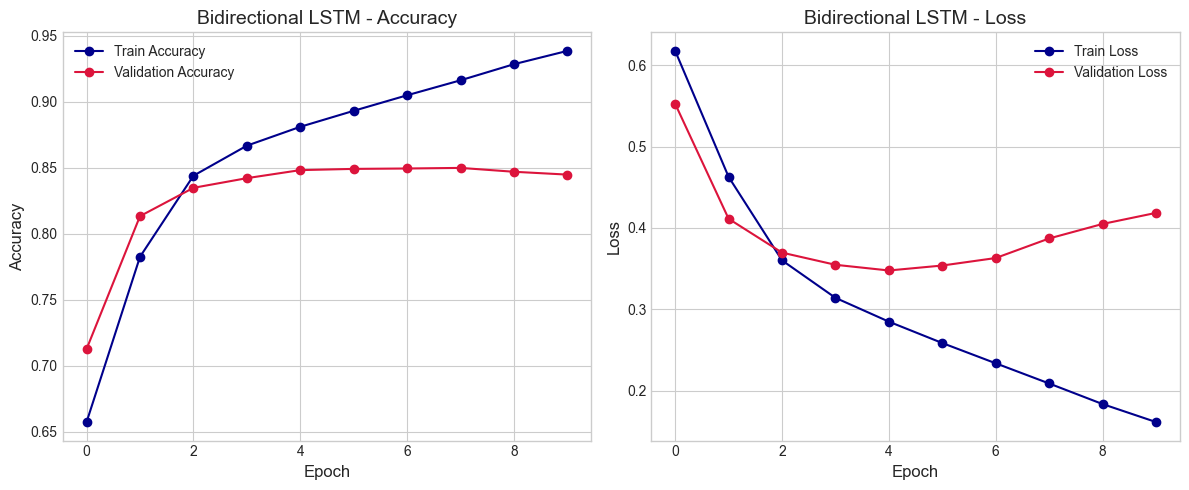

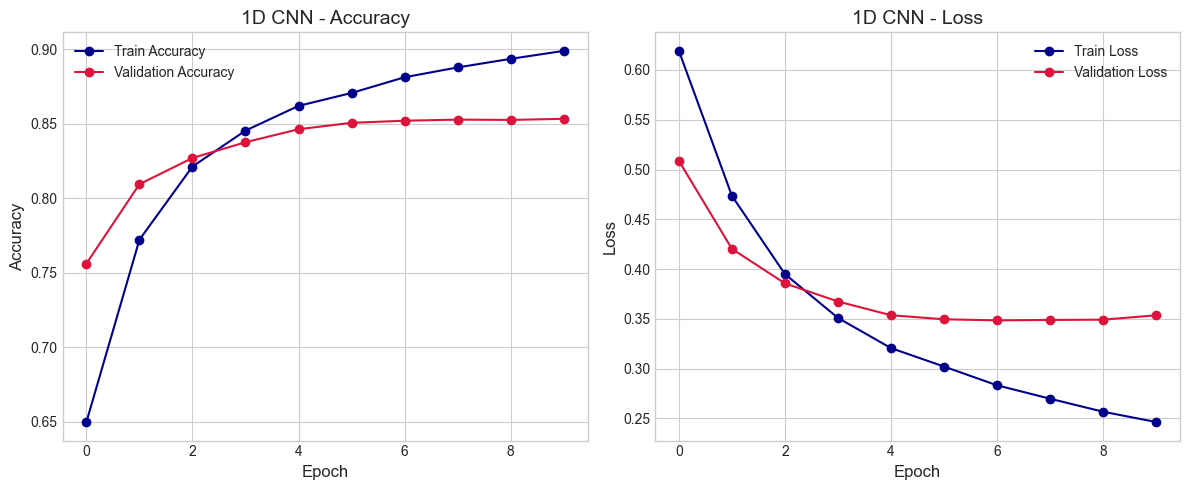

In [15]:
plot_history(bilstm_history, 'Bidirectional LSTM')
plot_history(cnn_history, '1D CNN')